## 加载py的库文件用于模型训练
<p>首先加载pytorch以及相关库文件，其中由于采用了自建数据集，因此对torch.utils.data中实现的加载数据集实例进行泛化以实现自己的数据集读取和训练过程</p>

In [1]:
import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import  Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
from copy import  deepcopy
import csv
import matplotlib.pyplot as plt

## 计算数据集的标准差和方差
<p>这里我们以训练集的均值和标准差为准，因此，为保证数据执行相同的操作，训练集和验证集都应该以这个值为准，通过均值和标准差，能够将数据进行很好的归一化操作，有利于数据集的训练过程</p>
<p>在代码中，通过均值和标准差，实现图像预处理。一般来说，通过此方法实现数据标准化，通过限制图像输入时的值范围，更加便于模型训练</p>

this is the avg and std, in order to adjust the value before training, it is a pretraining approach, tensor(263.3551) tensor(726.2202)


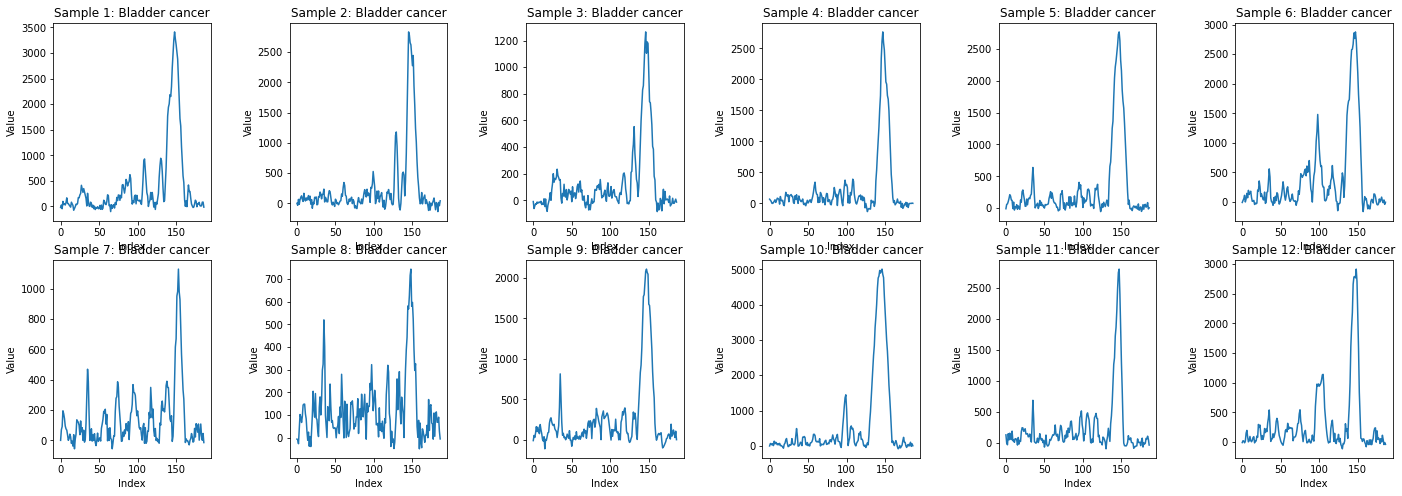

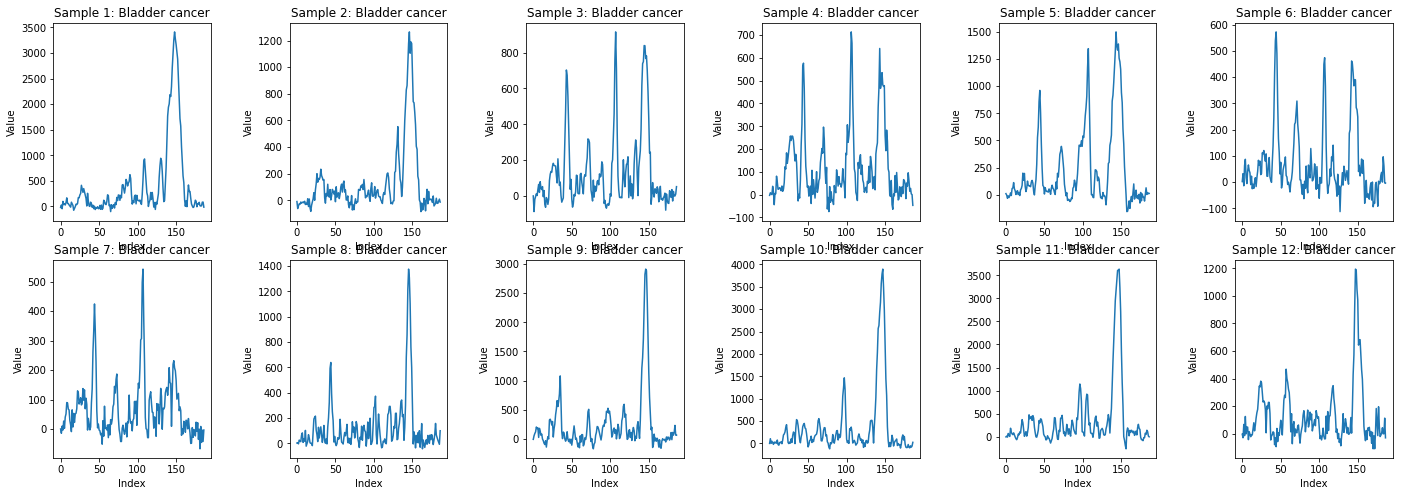

In [2]:
%matplotlib inline
# 用于数据读取
def read_data(file_path):
    data = np.loadtxt(file_path)
    X = torch.tensor(data[:, 0], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    y = torch.tensor(data[:, 1], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    return X, y
#用于计算均值和标准差
def calculate_mean_std(root_dir):
    all_y = []
    for cls_name in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, cls_name)
        if not os.path.isdir(class_dir):
            continue
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            if os.path.isfile(file_path) and file_name.endswith('.txt'):
                _, y = read_data(file_path)
                all_y.append(y)
    all_y = torch.cat(all_y, dim=0)
    mean = torch.mean(all_y)
    std = torch.std(all_y)
    return mean, std
#用于显示一些图像示例
def show_data_samples(root_dir, start_idx, end_idx, figsize=(8, 6)): # figsize控制图像的尺寸
    num_samples = end_idx - start_idx + 1
    num_cols = 6 #这里可以设置每行显示的图像个数
    num_rows = (num_samples + num_cols - 1) // num_cols
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=figsize)
    idx = 0
    for cls_name in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, cls_name)
        if not os.path.isdir(class_dir):
            continue
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            if os.path.isfile(file_path) and file_name.endswith('.txt'):
                _, y = read_data(file_path)
                idx += 1
                if idx >= start_idx and idx <= end_idx:
                    row = (idx - start_idx) // num_cols
                    col = (idx - start_idx) % num_cols
                    ax = axs[row, col]
                    ax.plot(y.squeeze().numpy())
                    ax.set_title(f'Sample {idx}: {cls_name}')
                    ax.set_xlabel('Index')
                    ax.set_ylabel('Value')
    plt.subplots_adjust(wspace=0.5)
    plt.show()
    
mean, std = calculate_mean_std('./train') # 由于对图像的标准化对于所有数据集应当做相同操作，这里我们计算出train数据集的标准差和均值，用于整个实验的标准化处理
print('this is the avg and std, in order to adjust the value before training, it is a pretraining approach,', mean, std)
show_data_samples('./train', 1, 12 , figsize=(24,8))
show_data_samples('./test', 1, 12, figsize=(24,8))

## 自建数据集读取
<p>自己设计一个数据读取方式，其中class_to_idx作为映射字典，在init过程中，通过这种方式将文件夹名称和对应的值（0，1，2，3....）进行映射，这样处理后，任意修改对应的value或者需要增加其他的癌症种类，仅需要在class_to_idx中做出修改即可，这个字典将在最后测试时也进行使用，以保证数据一致性</p>
<p>在实际操作过程中，在初始化阶段使用make_dataset读取数据，在具体调用以训练时，采用 getitem 得到结果，可以看到，X 表示提供数据中的第一列数据，y 表示提供数据中的第二列数据，label则表示文件夹对应的结果映射，即 class_to_idx 中的对应value，由于观察到 X 列数据完全一致，实际并没有区分数据的作用，对于神经网络来说，尤其是分类模型，这些数据仅仅作为杂项存在，于模型性能无益却可能干扰训练，因此实际并不使用，可以删去这个部分</p>

In [3]:
# 首先定义一个文件夹名称和对应值的映射，对于神经网络来说，需要预测键值对中的值
class_to_idx = {'Bladder cancer': 0, 
                'Colon cancer': 1, 
                'Healthy': 2, 
                'Prostatic cancer': 3}
# 用于读取自建数据集，这里我们不限制任何范围，若未来有修改读取数据集的需求，只要保持class_to_idx对应上文件夹名称即可，（任意分类类别皆可）
class CustomDataset(Dataset):
    def __init__(self, root_dir,  showimg, aug):
        self.showimg = showimg #判断是否在每一次给出对应训练数据时，显示数据的图像
        self.aug = aug # 判断是否进行数据增强
        self.root_dir = root_dir
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = class_to_idx
        self.idx_to_class = {idx: cls_name for cls_name, idx in self.class_to_idx.items()}
        self.samples = self._make_dataset()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, target = self.samples[idx]
        data = np.loadtxt(file_path)
        X = torch.tensor(data[:, 0], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        y = torch.tensor(data[:, 1], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        label = torch.tensor(target, dtype=torch.long)
        # 通过RandomExpand实现数据增强
        y_aug = self.RandomExpand(y.clone())
        if self.showimg == True:
            print('now drawing the pic the compare the difference between original and augmented data')
            # 通过DrawPic实现对应输出数据的图像绘制
            self.DrawPic(y.squeeze().numpy(), y_aug.squeeze().numpy(), file_path)
        return X, y_aug, label
    #实现数据集
    def _make_dataset(self):
        samples = []
        for cls_name in self.classes:
            class_dir = os.path.join(self.root_dir, cls_name)
            if not os.path.isdir(class_dir):
                continue
            for file_name in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file_name)
                if os.path.isfile(file_path) and file_name.endswith('.txt'):
                    samples.append((file_path, self.class_to_idx[cls_name]))
        return samples
    # 此代码实现数据增强，这里的思路是，通过读取对应数据，任意选择数据中region_size的区间，对此区间内的数据参入随机数，expand_factor表示参入的随机数的影响大小
    def RandomExpand(self, data):
        region_size, expand_factor = 0.2, 1.3
        channels, _, width = data.shape
        region_width = int(width * region_size)
        if self.aug == True:
            left = torch.randint(0, width - region_width + 1, (channels,))
            rands = torch.rand(channels, 1, region_width)
            # 由于生成的rands数据较粗糙，因此采用平均池化使它更加光滑
            rands = F.avg_pool1d(rands, kernel_size=7, stride=1, padding=3)
            data[:, :, left:left+region_width] += \
                        rands* data[:, :, left:left+region_width] * expand_factor
        # 最终通过标准差和均值实现数据标准化，另外，由于实际上数据的y轴具体值对数据分类影响较小，实际上分类应当基于y轴数据大小的差值，在深度学习里可以忽略y轴的标量值，因此也可以采用归一化方法实现数据预处理，实现如下
        # return (data - torch.min(data))/(torch.max(data) - torch.min(data))
        return (data - mean) / std
    # 实现数据对应的图像绘制
    def DrawPic(self, data_original, data_augmented, file_path):
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(data_original)
        plt.title("Original Data")
        
        plt.subplot(1, 2, 2)
        plt.plot(data_augmented)
        plt.title("Augmented Data")
        
        plt.suptitle(file_path)
        plt.show()

## 定义一个好玩的小模型
<p>首先在这里MultiHeadedAttention 定义了一个基于多头注意力和Linformer实现的超轻量化注意力结构（Self-Attention一系列的全局注意力方法），EffectiveChannelAttention模型则是ECA通道注意力机制，MultiScaleResidualBlock则是残差结构块</p>
<p>实际上，经过实践发现MultiHeadedAttention的低秩矩阵实现全局注意力机制的思路不适用</p>

In [4]:
def attention(query, key, value):
    dim = query.shape[2]
    scores = torch.einsum('bdwn,bdwm->bnwm', query, key) / dim**.5
    prob = torch.nn.functional.softmax(scores, dim=-1)
    return torch.einsum('bnwm,bdwm->bdwn', prob, value), prob
# 多头Linformer自注意力机制
class MultiHeadedAttention(nn.Module):
    def __init__(self, num_heads: int, d_model: int):
        super().__init__()
        assert d_model % num_heads == 0
        self.dim = d_model // num_heads
        self.num_heads = num_heads
        self.decrease = d_model // 4
        self.merge = nn.Conv2d(d_model, d_model, kernel_size=1, groups=d_model) 
        
        self.V = nn.Conv2d(d_model, d_model, kernel_size=1, groups=d_model)
        self.Q = nn.Conv2d(d_model, self.decrease, kernel_size=1, groups=self.decrease)
        self.K = nn.Conv2d(d_model, self.decrease, kernel_size=1, groups=self.decrease) 
    
    def forward(self, query, key, value):
        batch_dim = query.size(0)
        query = self.Q(query).view(batch_dim, self.decrease//self.num_heads, self.num_heads, -1)
        key = self.K(key).view(batch_dim, self.decrease//self.num_heads, self.num_heads, -1)
        value = self.V(value).view(batch_dim, self.dim, self.num_heads, -1)
        x, _ = attention(query, key, value)
        return self.merge(x.contiguous().view(batch_dim, self.dim*self.num_heads, 1, -1)) 
# 通道注意力机制，通过对通道进行卷积，强化具有有效权值的卷积核
class EffectiveChannelAttention(nn.Module):
    def __init__(self, forsee=3):
        super(EffectiveChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.conv = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=forsee, padding=int(forsee/2), bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        out = self.avg_pool(inputs)
        out = self.conv(out.squeeze(-1).transpose(-1,-2)).transpose(-1,-2).unsqueeze(-1)
        out = self.sigmoid(out)
        return out*inputs
# 残差块，用于堆叠网络结构
class MultiScaleResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, groups=1, stride=1):
        super(MultiScaleResidualBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.groups = groups
        self.stride = stride
        # 在残差块中包含一个Conv2d和空洞卷积的Conv2d的顺序结构，空洞卷积即卷积核具有间隙3x3大小的卷积核在dilation=1时，感受野范围为5x5，其目的是在参数量不变的前提下尽可能扩大卷积核的感受野范围
        self.ResidualLayer = nn.Sequential(
            nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=(1,3), stride=self.stride, padding=(0,1),  groups=self.groups),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(self.out_channels),
            nn.Conv2d(in_channels=self.out_channels, out_channels=self.out_channels, kernel_size=(1,3), stride=1, padding=(0,2), groups= self.groups, dilation=2),
        )
        # shortcut用于在模型输入输出通道不同时，调整通道
        self.shortcut = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=(1,1), stride=self.stride, padding=(0,0), groups= self.groups)
        self.relu = nn.LeakyReLU(0.1, inplace=True)
        self.bnout = nn.BatchNorm2d(self.out_channels)
        
    def forward(self, x):
        out = self.ResidualLayer(x) 
        tmp = self.shortcut(x)
        if self.in_channels != self.out_channels:
            out = out + tmp
        else:
            out = out + x
        out = self.relu(out)
        out = self.bnout(out)
        return out
# 模型完全体，其中，我们将模型分为编码器和解码器两大部分，编码器负责抽取局部特征，解码器负责实现最终特征映射
class Model(nn.Module):
    def __init__(self, num_class=4):
        super(Model, self).__init__()
        self.num_class = num_class
        self.convinput = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=1, stride=1,  padding=0),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.AvgPool2d(kernel_size=(1,2), stride=(1,2), padding=(0,0)),
        )
        # 编码器中，stride=2的卷积操作可以完全代替池化层实现特征尺度减半的效果
        self.encoder = nn.Sequential(
            MultiScaleResidualBlock(64, 64, groups=1, stride = 1),
            MultiScaleResidualBlock(64, 128, groups=1, stride=2),
            EffectiveChannelAttention(3),
            MultiScaleResidualBlock(128, 128, groups=1, stride = 1),
            MultiScaleResidualBlock(128, 256, groups=1, stride = 2),
            EffectiveChannelAttention(3),
            MultiScaleResidualBlock(256, 256, groups=1, stride = 1),
            MultiScaleResidualBlock(256, 512, groups=1, stride = 2),
            EffectiveChannelAttention(3),
            MultiScaleResidualBlock(512, 512, groups=1, stride = 1),
            MultiScaleResidualBlock(512, 256, groups=1, stride = 2),
            EffectiveChannelAttention(3),
        )
        # 若要使用多头Linformer，则取消这里的注释
        # self.linearformer = MultiHeadedAttention(4, 256)
        self.decoder = nn.Sequential(
            MultiScaleResidualBlock(256, 256, groups=1, stride = 1),
            MultiScaleResidualBlock(256, 256, groups=1, stride = 1),
            nn.Conv2d(in_channels=256, out_channels=self.num_class, kernel_size=(1,3), stride=1, padding=(0,1)),
            # 这里使用全局均值池化，目的是将任意（b，c，h，w）的数据转化为（b，c，1，1），其中 c 通道则表示分类的类别数量，这样可以避免使用Linear产生的模型限制，若训练得当，可以输入任意长度的一维数据实现分类
            nn.AdaptiveAvgPool2d((1,1)),
            # sigmoid将数据限制在 0-1 区间，以匹配交叉熵或者二元交叉熵实现损失计算
            nn.Sigmoid(),
        )
        
    def forward(self, inputs):
        out = self.convinput(inputs)
        
        out = self.encoder(out)
        # 若要使用多头Linformer，则取消这里的注释
        # out = self.linearformer(out, out, out)
        out = self.decoder(out)
        out = torch.flatten(out, 1)
        return out

## 准备训练
<p>定义好数据集，这里有一个问题，发现原数据无论构建任意形式的模型，训练集数据在100%时，测试集数据始终在80%无法上升，推测可能训练集数据无法完整确定分类的边界，测试集数据和训练集数据两者在其域空间内交集较少，难以实现有效的泛化</p>
<p>因此，在当前的训练集中，我们加入了测试集的数据，所幸通过数据增强，与实际的测试集数据必然不同，若数据集足够，则建议训练集和测试集完全分开</p>

now drawing the pic the compare the difference between original and augmented data


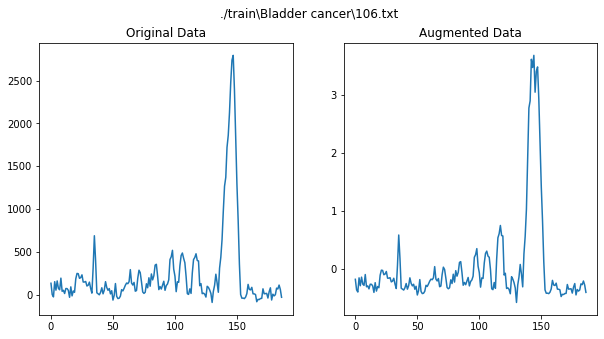

X  size is : torch.Size([1, 1, 187]) 
 y size is :  torch.Size([1, 1, 187]) 
 the label is : tensor(0) 
 corresponding to labels: Bladder cancer

 now we are training on  device :  cuda 
 trying to empty the cuda ...


In [26]:
%matplotlib inline
# 定义配置，分别是文件夹路径，训练批次，学习率，学习权重衰减值，学习的循环次数
Config = {
    'trainpath':'./train',
    'valpath':'./test',
    'testpath':'./test',
    'batch-size': 100,
    'lr':0.00005,
    'gamma': 0.94,
    'epoch': 150,
}

# 获取数据集路径，可以看到这里valDataset和testDataset共享同一个路径（数据量问题，若充足，则可分开），只有trainDataset使用数据增强
trainDataset = CustomDataset(root_dir=Config['trainpath'], showimg = True, aug = True)
valDataset = CustomDataset(root_dir=Config['valpath'], showimg = False, aug = False)
testDataset = CustomDataset(root_dir=Config['testpath'], showimg = False, aug = False)
# 设置一个样本观察数据增强的效果，见下图
tmp = trainDataset[10]
X, y, label = tmp[0], tmp[1], tmp[2]
print('X  size is :', X.size(),'\n', 'y size is : ', y.size(), '\n', 'the label is :' , label,'\n','corresponding to labels:', trainDataset.idx_to_class[label.item()])
# 规划数据集的训练batch-size，确定数据集是否需要打乱顺序 shuffle=True（对于val和test来说实际上是不需要的）
trainDataset.showimg = False
trainloader = DataLoader(trainDataset, batch_size=Config['batch-size'], shuffle=True)
valloader = DataLoader(valDataset, batch_size=Config['batch-size'], shuffle=True)
testloader = DataLoader(testDataset, batch_size=1, shuffle=False)
# 确定训练的机器
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('\n now we are training on  device : ', device, '\n trying to empty the cuda ...')
torch.cuda.empty_cache()
# 确定损失函数为交叉熵损失，优化器为Adam，并且通过学习率衰减实现更加精细的训练，其中每一个epoch的学习率 = lr * gamma^epoch 的次方
criterion = nn.CrossEntropyLoss()
model = Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=Config['lr'], betas=(0.9,0.99), eps=1e-6, weight_decay=0.0005, amsgrad=False)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=Config['gamma'])

## 设置训练和验证模型的代码

In [14]:
# 定义训练函数
def train(epoch):
    model.train()
    train_loss = 0
    count = 0
    back_loss = 0
    total = 0
    back_acc = 0
    correct = 0
    for i, (_, y, label) in enumerate(trainloader):
        optimizer.zero_grad()
        y = y.to(device)
        label = label.to(device).float()
        output = model(y)
        loss = criterion(output,label.long())
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _,predicted = output.max(1)
        total += label.size(0)
        correct += predicted.eq(label).sum().item()
        back_loss = train_loss/(i+1)
        back_acc = 100.*correct/total
    print('epoch: ', epoch, "train loss and acc: {:.4f}, {:.4f}".format(back_loss, back_acc))
    return back_loss, back_acc
# 定义验证函数，交训练函数，它不需要实现loss.backward损失返回，并且使用model.eval()关闭了BatchNormal等用于抑制模型过拟合的正则化层，提升推理速度
def val(epoch):
    model.eval()
    train_loss = 0
    count = 0
    back_loss = 0
    total = 0
    back_acc = 0
    correct = 0
    
    for i,(_, y,label) in enumerate(valloader):
        y = y.to(device)
        label = label.to(device).float()
        output = model(y)
        loss = criterion(output,label.long())
        
        train_loss += loss.item()
        _,predicted = output.max(1)
        total += label.size(0)
        correct += predicted.eq(label).sum().item()
        back_loss = train_loss/(i+1)
        back_acc = 100.*correct/total
    print("val loss and acc: {:.4f}, {:.4f} \n".format(back_loss, back_acc))
    return back_loss, back_acc

## 正式训练
<p>注意，原有数据集训练时，测试集数据准确率保持在79.6276%而训练集的数据准确率保持在100%，推断由于数据量少导致此问题，因此将test数据集也加入到train数据集中，但是依靠数据增强的手段，实际训练时的数据与test数据集不同</p>

In [15]:
# 保存准确率和损失用于
trainloss_save = []
trainacc_save = []
valloss_save = []
valacc_save = []
# 用于保存四组模型，分别为最优训练/验证损失，以及最优训练/验证准确率的模型
best_models = {
    'valacc': (0, 'best_valacc.pth'),
    'valloss': (float('inf'), 'best_valloss.pth'),
    'trainacc': (0, 'best_trainacc.pth'),
    'trainloss': (float('inf'), 'best_trainloss.pth')
}
with open('train.csv', 'w', newline='') as wd:
    writer = csv.writer(wd)
    for epoch in range(Config['epoch']):
        trainloss, trainacc = train(epoch)
        valloss, valacc = val(epoch)
        # 这里实现了每一个epoch，lr对应的学习率权重衰减一次的过程，gamma即为对应的乘数，lr = lr * gamma^epoch
        scheduler.step()
        
        trainloss_save.append(trainloss)
        trainacc_save.append(trainacc)
        valloss_save.append(valloss)
        valacc_save.append(valacc)
        
        if valacc > best_models['valacc'][0]:
            best_models['valacc'] = (valacc, 'best_valacc.pth')
            torch.save(model, 'best_valacc.pth')

        if valloss < best_models['valloss'][0]:
            best_models['valloss'] = (valloss, 'best_valloss.pth')
            torch.save(model, 'best_valloss.pth')

        if trainacc > best_models['trainacc'][0]:
            best_models['trainacc'] = (trainacc, 'best_trainacc.pth')
            torch.save(model, 'best_trainacc.pth')

        if trainloss < best_models['trainloss'][0]:
            best_models['trainloss'] = (trainloss, 'best_trainloss.pth')
            torch.save(model, 'best_trainloss.pth')
        # 保存训练时的损失和准确率变化，保存至 train.csv 文件中
        writer.writerow((trainloss, trainacc, valloss, valacc))
        
        torch.save(model,'./model.pth')
        

epoch:  0 train loss and acc: 1.3628, 33.8095
val loss and acc: 1.3849, 25.9843 

epoch:  1 train loss and acc: 1.2995, 63.1746
val loss and acc: 1.3912, 25.9843 

epoch:  2 train loss and acc: 1.2548, 72.3810
val loss and acc: 1.3860, 25.9843 

epoch:  3 train loss and acc: 1.1995, 81.7460
val loss and acc: 1.3895, 25.1969 

epoch:  4 train loss and acc: 1.1488, 87.6190
val loss and acc: 1.3559, 31.4961 

epoch:  5 train loss and acc: 1.1036, 90.4762
val loss and acc: 1.3116, 41.7323 

epoch:  6 train loss and acc: 1.0581, 91.5873
val loss and acc: 1.1759, 63.7795 

epoch:  7 train loss and acc: 1.0177, 93.9683
val loss and acc: 1.0957, 81.8898 

epoch:  8 train loss and acc: 0.9912, 92.8571
val loss and acc: 1.0251, 81.8898 

epoch:  9 train loss and acc: 0.9602, 94.9206
val loss and acc: 0.9905, 82.6772 

epoch:  10 train loss and acc: 0.9546, 95.3968
val loss and acc: 0.9338, 83.4646 

epoch:  11 train loss and acc: 0.9324, 95.2381
val loss and acc: 0.9046, 84.2520 

epoch:  12 tra

## 进行绘图
绘制损失函数和准确率

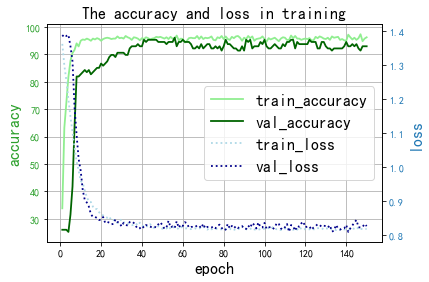

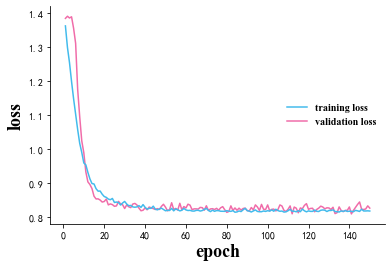

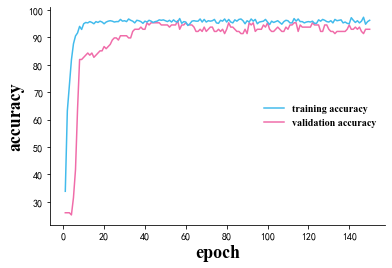

In [37]:
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


def get_data(file_path):
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    with open(file_path, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            # 将每行数据解析为对应的四类数据
            train_loss.append(float(row[0]))
            train_acc.append(float(row[1]))
            val_loss.append(float(row[2]))
            val_acc.append(float(row[3]))
        return train_loss, train_acc, val_loss, val_acc
            
# 用于绘制不同的线，通过调节可以使线产生标记点，也可以调节颜色粗细等，这里的 marker 可以使用  ^ + = --  做出不同的标记点
def plot_line(xlabel, ylabel, ax, cmap='winter', marker='o', colors='b', isshow=False, show='lr', sattle_scatter=True):
    max_indx = np.argmax(ylabel)
    show_max = str(np.around(ylabel[max_indx], decimals=4))
    if isshow:
        plt.annotate(show_max, xy=(
            xlabel[-2], ylabel[max_indx]), xytext=(xlabel[-40], ylabel[max_indx]+0.1))
    y = np.array(ylabel)
    norm = plt.Normalize(y.min(), y.max())
    norm_y = norm(y)
    if show == 'lr':
        line, = plt.plot(xlabel, ylabel, c=colors, linewidth=1.5)
        if sattle_scatter == True:
            plt.scatter(xlabel, ylabel, marker=marker,
                        c=norm_y, cmap=cmap, s=1)
    else:
        line, = ax.plot(xlabel, ylabel, c=colors,
                        linewidth=1.8, linestyle=marker)
    return line

# 用于实现单轴的图像绘制，仅单次展现acc或者loss
def train_draw_oneline(epoch, types, savename, path):
    train_loss, train_acc, val_loss, val_acc = get_data(path)
    labelfont, legendfont = 18, 22
    x = np.linspace(1, epoch, epoch)
    fig, ax = plt.subplots()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xlabel('epoch', fontdict={
               'family': 'Times New Roman', 'size': labelfont}, fontweight='bold')
    if types == 'accuracy':
        plt.ylabel('accuracy', fontdict={
                   'family': 'Times New Roman', 'size': labelfont}, fontweight='bold')
        val_acc = plot_line(x, val_acc, 0, colors=(
            240/255.0, 108/255.0, 169/255.0), sattle_scatter=False)
        train_acc = plot_line(x, train_acc, 0, colors=(
            66/255.0, 187/255.0, 236/255.0), sattle_scatter=False)
        plt.legend([train_acc, val_acc], ['training accuracy', 'validation accuracy'], fontsize=legendfont,
                   loc='center right', frameon=False, prop={'family': 'Times New Roman', 'weight': 'bold'})
    else:
        plt.ylabel('loss', fontdict={
                   'family': 'Times New Roman', 'size': labelfont}, fontweight='bold')
        val_loss = plot_line(x, val_loss, 0, colors=(
            240/255.0, 108/255.0, 169/255.0), sattle_scatter=False)
        train_loss = plot_line(x, train_loss, 0, colors=(
            66/255.0, 187/255.0, 236/255.0), sattle_scatter=False)
        plt.legend([train_loss, val_loss], ['training loss', 'validation loss'], fontsize=legendfont,
                   loc='center right', frameon=False, prop={'family': 'Times New Roman', 'weight': 'bold'})
    plt.savefig(savename, dpi=600, bbox_inches='tight')
    plt.show()

# 用于实现双轴的图像绘制，将acc和loss同时展现
def train_draw(epoch, savename, path):  
    train_loss, train_acc, val_loss, val_acc = get_data(path)
    x = np.linspace(1, epoch, epoch)

    fig, ax1 = plt.subplots()
    plt.grid(True)
    ax1.set_xlabel("epoch", fontsize=16)
    ax1.set_ylabel("accuracy", fontsize=16, color='tab:green')
    ax1.tick_params(axis='y', labelcolor='tab:green')
    train_acc = plot_line(
        x, train_acc, ax1, colors='lightgreen', marker='-', show='train')
    val_acc = plot_line(x, val_acc, ax1, cmap='inferno',
                        colors='darkgreen', marker='-', show='train')

    ax2 = ax1.twinx()
    ax2.set_ylabel('loss', fontsize=16, color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    train_loss = plot_line(
        x, train_loss, ax2, colors='lightblue', marker=':', show='train')
    val_loss = plot_line(x, val_loss, ax2, colors='darkblue',
                         marker=':', show='train')

    plt.title("The accuracy and loss in training", fontsize=16)
    plt.legend([train_acc, val_acc, train_loss, val_loss], ['train_accuracy',
               'val_accuracy', 'train_loss', 'val_loss'], fontsize=16, loc='center right')
    plt.savefig(savename, dpi=600, bbox_inches='tight')
    plt.show()
# 依赖训练时提供的配置参数，双轴图像保存在combine.tiff文件中
train_draw(Config['epoch'],  'combine.tiff', 'train.csv')
# 单轴图像在绘制时需要确定types="loss" or "accuracy"
train_draw_oneline(Config['epoch'], 'loss', 'loss.tiff', 'train.csv')
train_draw_oneline(Config['epoch'], 'accuracy', 'accuracy.tiff', 'train.csv')

## 计算混淆矩阵

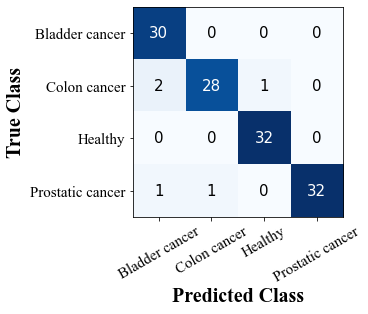

In [31]:
# 混淆矩阵的计数功能
def confusion_matrix(preds, labels, conf_matrix):
    pred = torch.argmax(preds, 1)
    for p, t in zip(pred, labels):
        conf_matrix[p, t] += 1
    return conf_matrix
# 通过模型在 testloader 数据集上的运行搜集结果绘制混淆矩阵
def neteval(path, matrix, labels, testloader, savename):
    labelfont, fontsin=20, 15
    net = torch.load(path).cpu()
    # 设置混淆矩阵的行列
    conf_matrix = torch.zeros(matrix[0], matrix[1])
    net.eval()
    # 实际推理过程
    with torch.no_grad():
        for batch_idx, (_, inputs, targets) in enumerate(testloader):
            inputs = inputs
            outputs = net(inputs)
            conf_matrix = confusion_matrix(outputs, targets, conf_matrix)
    conf_matrix = np.array(conf_matrix)
    corrects = conf_matrix.diagonal(offset=0)
    per_kinds = conf_matrix.sum(axis=1)

    plt.imshow(conf_matrix, cmap=plt.cm.Blues)
    thresh = conf_matrix.max()/2
    # 用于输入数据，确定y/x轴的标签
    for x in range(matrix[0]):
        for y in range(matrix[0]):
            info = int(conf_matrix[y, x])
            plt.text(x, y, str(info), verticalalignment='center', horizontalalignment='center', fontsize=fontsin, color='white' if info > thresh else 'black')
            # 若想将数据以百分比的形式展现出来，则使用下面的示例
            # plt.text(x, y, info if info == 0 else int(round(float(info)/127.0, 3)*100.0), verticalalignment='center', horizontalalignment='center', fontsize=fontsin, color='white' if info > thresh else 'black')
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.yticks(range(matrix[0]), labels, fontdict={'family': 'Times New Roman', 'fontsize': fontsin})
    plt.ylabel("True Class", fontdict={'family': 'Times New Roman', 'fontsize': labelfont}, fontweight='bold')
    plt.xticks(range(matrix[0]), labels, rotation=30, fontdict={
               'family': 'Times New Roman', 'fontsize': fontsin})
    plt.xlabel("Predicted Class", fontdict={'family': 'Times New Roman', 'fontsize': labelfont}, fontweight='bold')
    plt.savefig(savename, dpi=600, bbox_inches='tight')
    plt.show()
# neteval函数输入分别是（模型路径，类别数量，类别的标签名称（用于在x/y轴显示），加载的数据集（已经分好batch-size），保存图片的路径）
neteval('./best_valacc.pth', [len(class_to_idx), len(class_to_idx)],  class_to_idx.keys(), testloader, savename='confusion.tiff')  # 这个画混淆矩阵